<a href="https://colab.research.google.com/github/ujs/open_data/blob/master/Facebook_Metrics_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Define Problem**










Week 4 answer

I like the visualizations in this article- https://www.bloomberg.com/graphics/2019-california-housing-crisis/ 
The visualizations are interactive and allow the reader to hover over the graphs and discover new insights. For example the screenshot below is an interactive graph explaining what percentage of residents are burdened by high rents across different income brackets in various cities. Without much effort, the reader can see that cities in California impose a higher cost burden on their residents.
I changed the color palette and background color of subplots for clarity.
I increased the font size of the labels and title for readability. I changed the xticklabels and replaced them by text so that viewers can easily understand which weekday does each box correspond to.


In [0]:
#Importing the necessary visualisation adn data analysis libraries
import pandas as pd
import numpy as np
import math
import statsmodels as sm
import sklearn as skl
import seaborn as sns
import matplotlib.pyplot as plt
import fancyimpute
import missingno as mn
from sklearn import decomposition, preprocessing, cluster, tree
from yellowbrick.cluster.silhouette import SilhouetteVisualizer
import pydotplus
from scipy.cluster import hierarchy


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [1]:
!unzip 'https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip' -d /content

unzip:  cannot find or open https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip, https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip.zip or https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip.ZIP.


# **Load and Clean Data**

In [0]:
original_data = pd.read_csv('dataset_Facebook.csv', delimiter = ';')
    

original_data.head()


,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,Photo,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


In [0]:
# Looking at the data types of columns
original_data.dtypes

Page total likes                                                         int64
Type                                                                    object
Category                                                                 int64
Post Month                                                               int64
Post Weekday                                                             int64
Post Hour                                                                int64
Paid                                                                   float64
Lifetime Post Total Reach                                                int64
Lifetime Post Total Impressions                                          int64
Lifetime Engaged Users                                                   int64
Lifetime Post Consumers                                                  int64
Lifetime Post Consumptions                                               int64
Lifetime Post Impressions by people who have liked y

In [0]:
original_data.shape

(500, 19)

In [0]:
#Investigating missing values
original_data.isna().sum()

Page total likes                                                       0
Type                                                                   0
Category                                                               0
Post Month                                                             0
Post Weekday                                                           0
Post Hour                                                              0
Paid                                                                   1
Lifetime Post Total Reach                                              0
Lifetime Post Total Impressions                                        0
Lifetime Engaged Users                                                 0
Lifetime Post Consumers                                                0
Lifetime Post Consumptions                                             0
Lifetime Post Impressions by people who have liked your Page           0
Lifetime Post reach by people who like your Page   

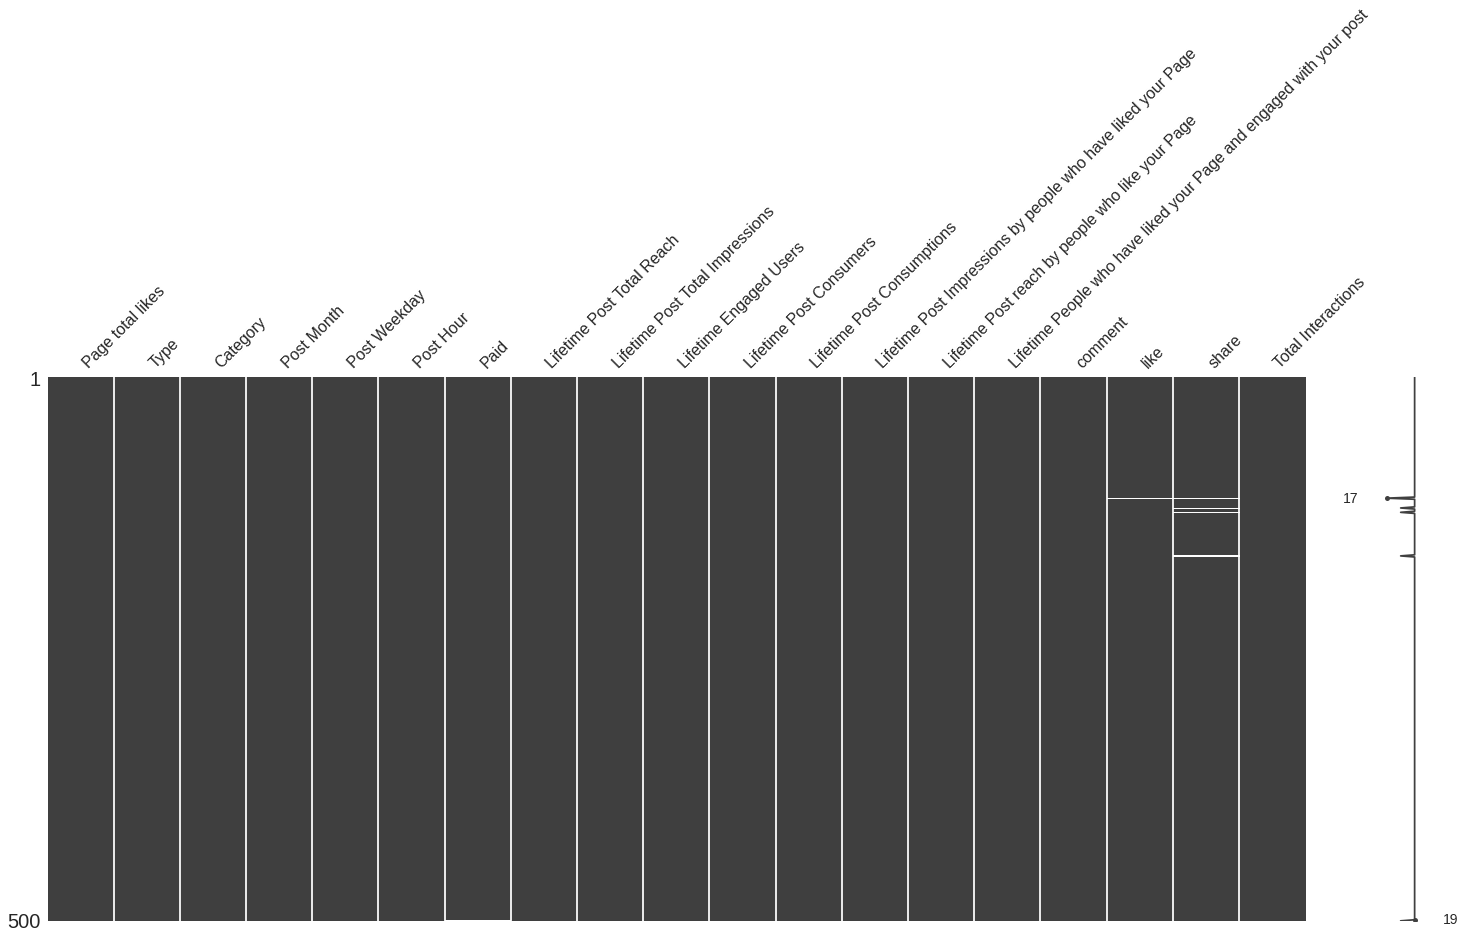

In [0]:
mn.matrix(original_data)

In [0]:
original_data.Type.value_counts(dropna = False)

Photo     426
Status     45
Link       22
Video       7
Name: Type, dtype: int64

In [0]:
#Function that inputs original dataframe and outputs cleaned dataframe
def clean_df(original_data):
  df = original_data.copy()
  df.dropna(subset = ['Paid'], inplace = True)
  df.fillna(0, inplace = True)
  return df

df = clean_df(original_data)
df.isna().sum().sum()

0

In [0]:
df.Paid.value_counts()

0.0    360
1.0    139
Name: Paid, dtype: int64

In [0]:
df.Category.value_counts()

1    215
3    155
2    129
Name: Category, dtype: int64

In [0]:
df['Post Weekday'].value_counts()

7    82
6    81
4    71
1    68
5    67
2    66
3    64
Name: Post Weekday, dtype: int64

In [0]:
df['Post Month'].value_counts()

10    60
7     52
12    50
4     50
6     49
11    45
5     37
9     36
3     36
8     34
2     26
1     24
Name: Post Month, dtype: int64

In [0]:
#Total number of pages
len(df['Page total likes'].value_counts()) 

90

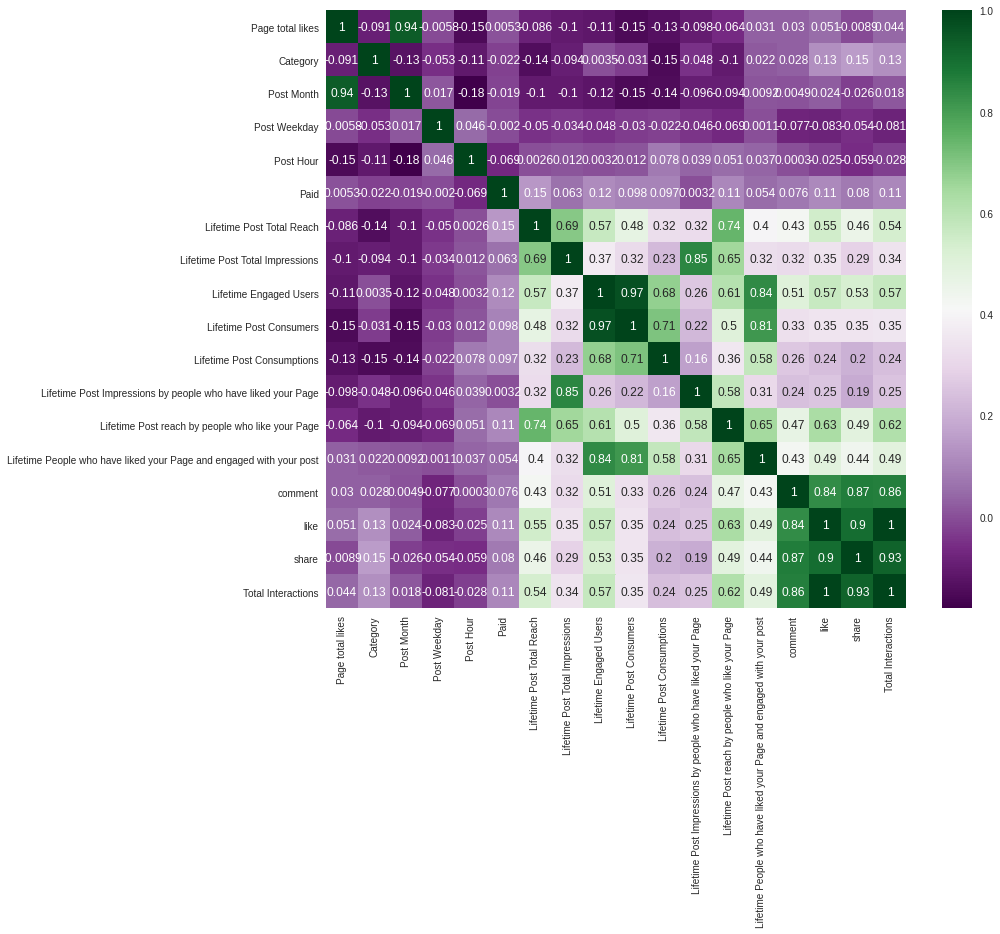

In [0]:
plt.figure(figsize=(13,11))
sns.heatmap(df.corr(),cmap='PRGn' ,annot=True)

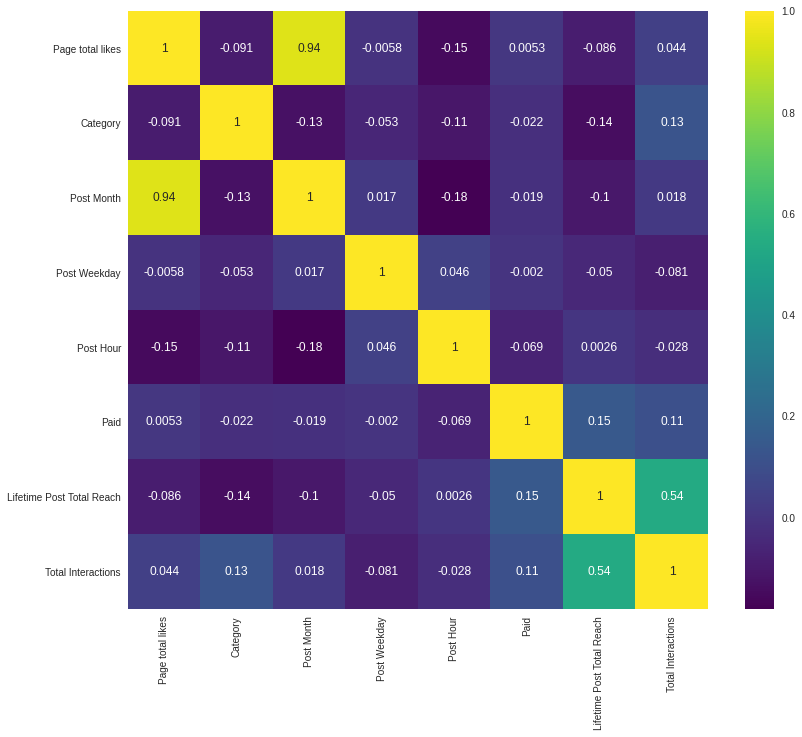

In [0]:
#Zoom into only input variable and a couple of output variables
modified_df = df.drop(df.columns[8:-1], axis = 1)
plt.figure(figsize=(13,11))
sns.heatmap(modified_df.corr(),cmap='viridis' ,annot=True)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


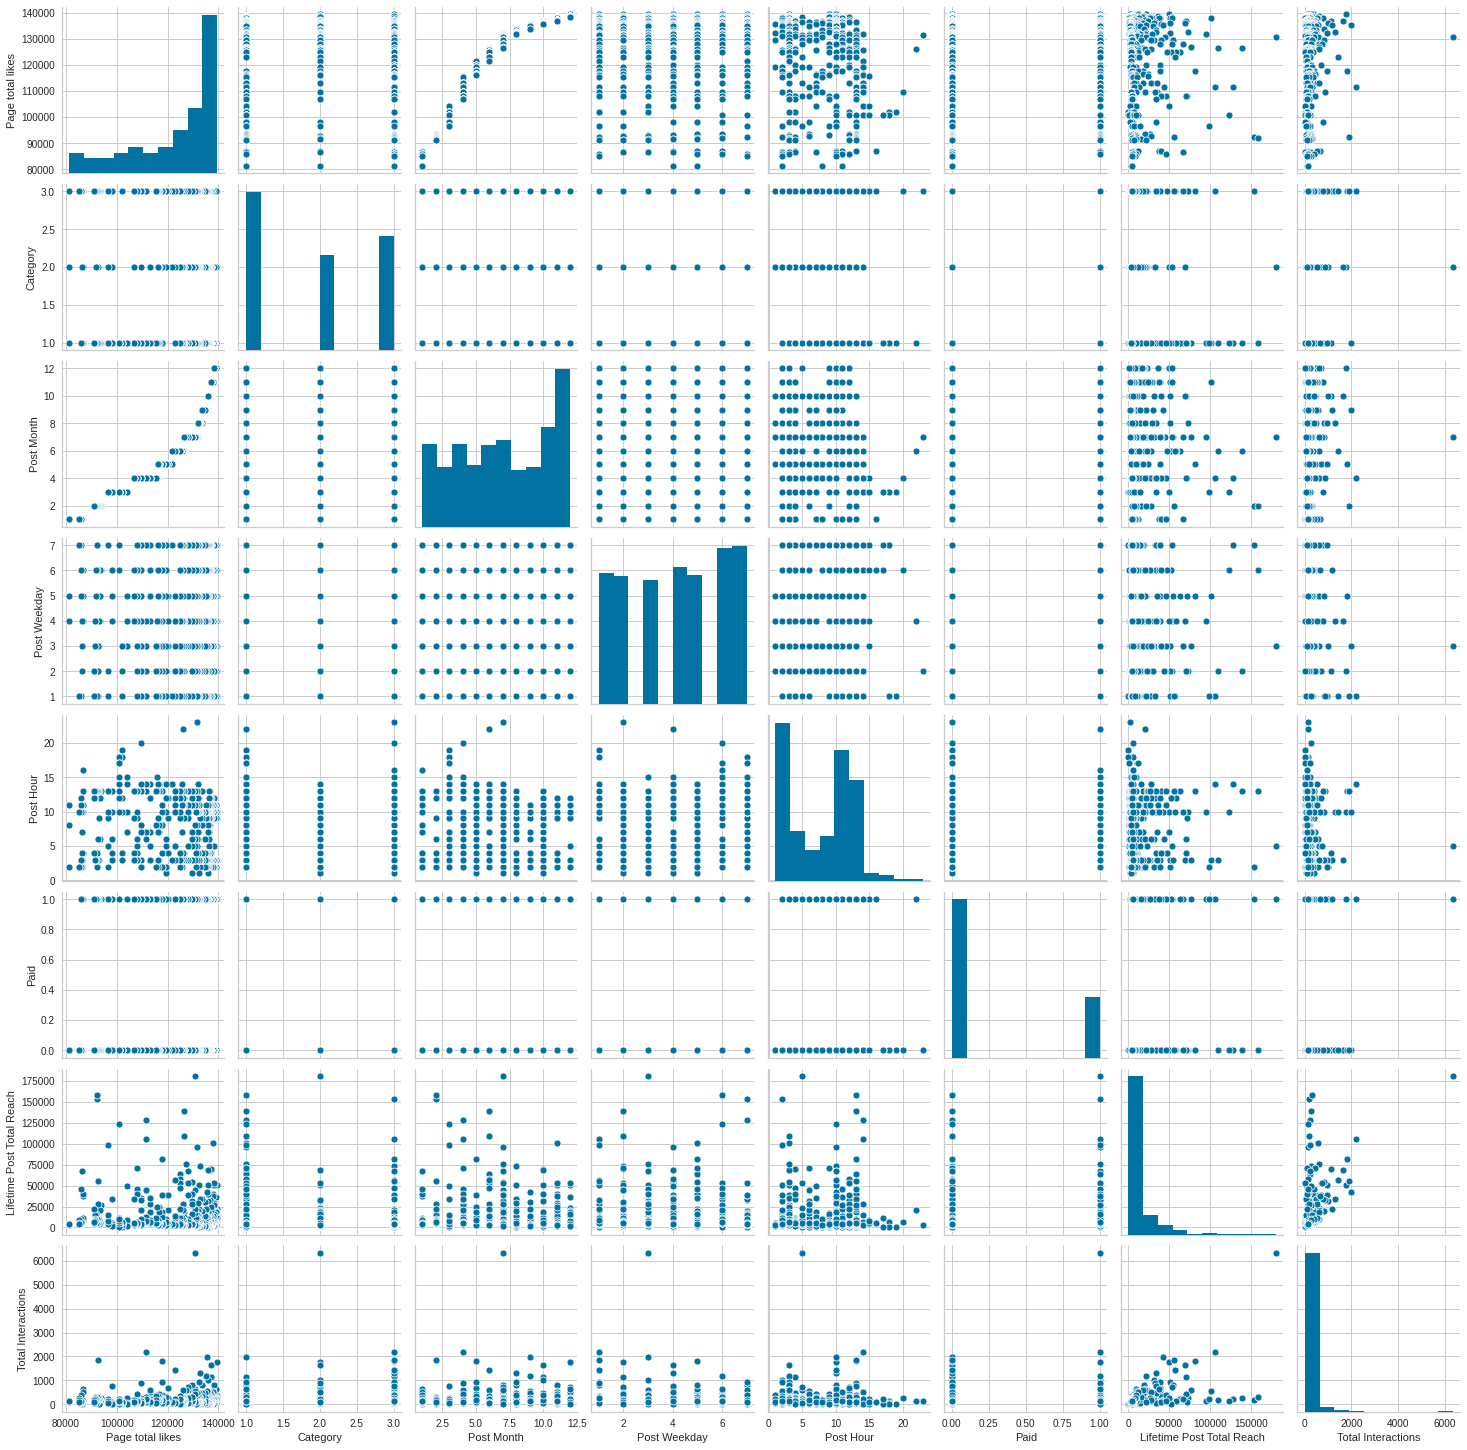

In [0]:

sns.pairplot(data = modified_df, size=2.5)

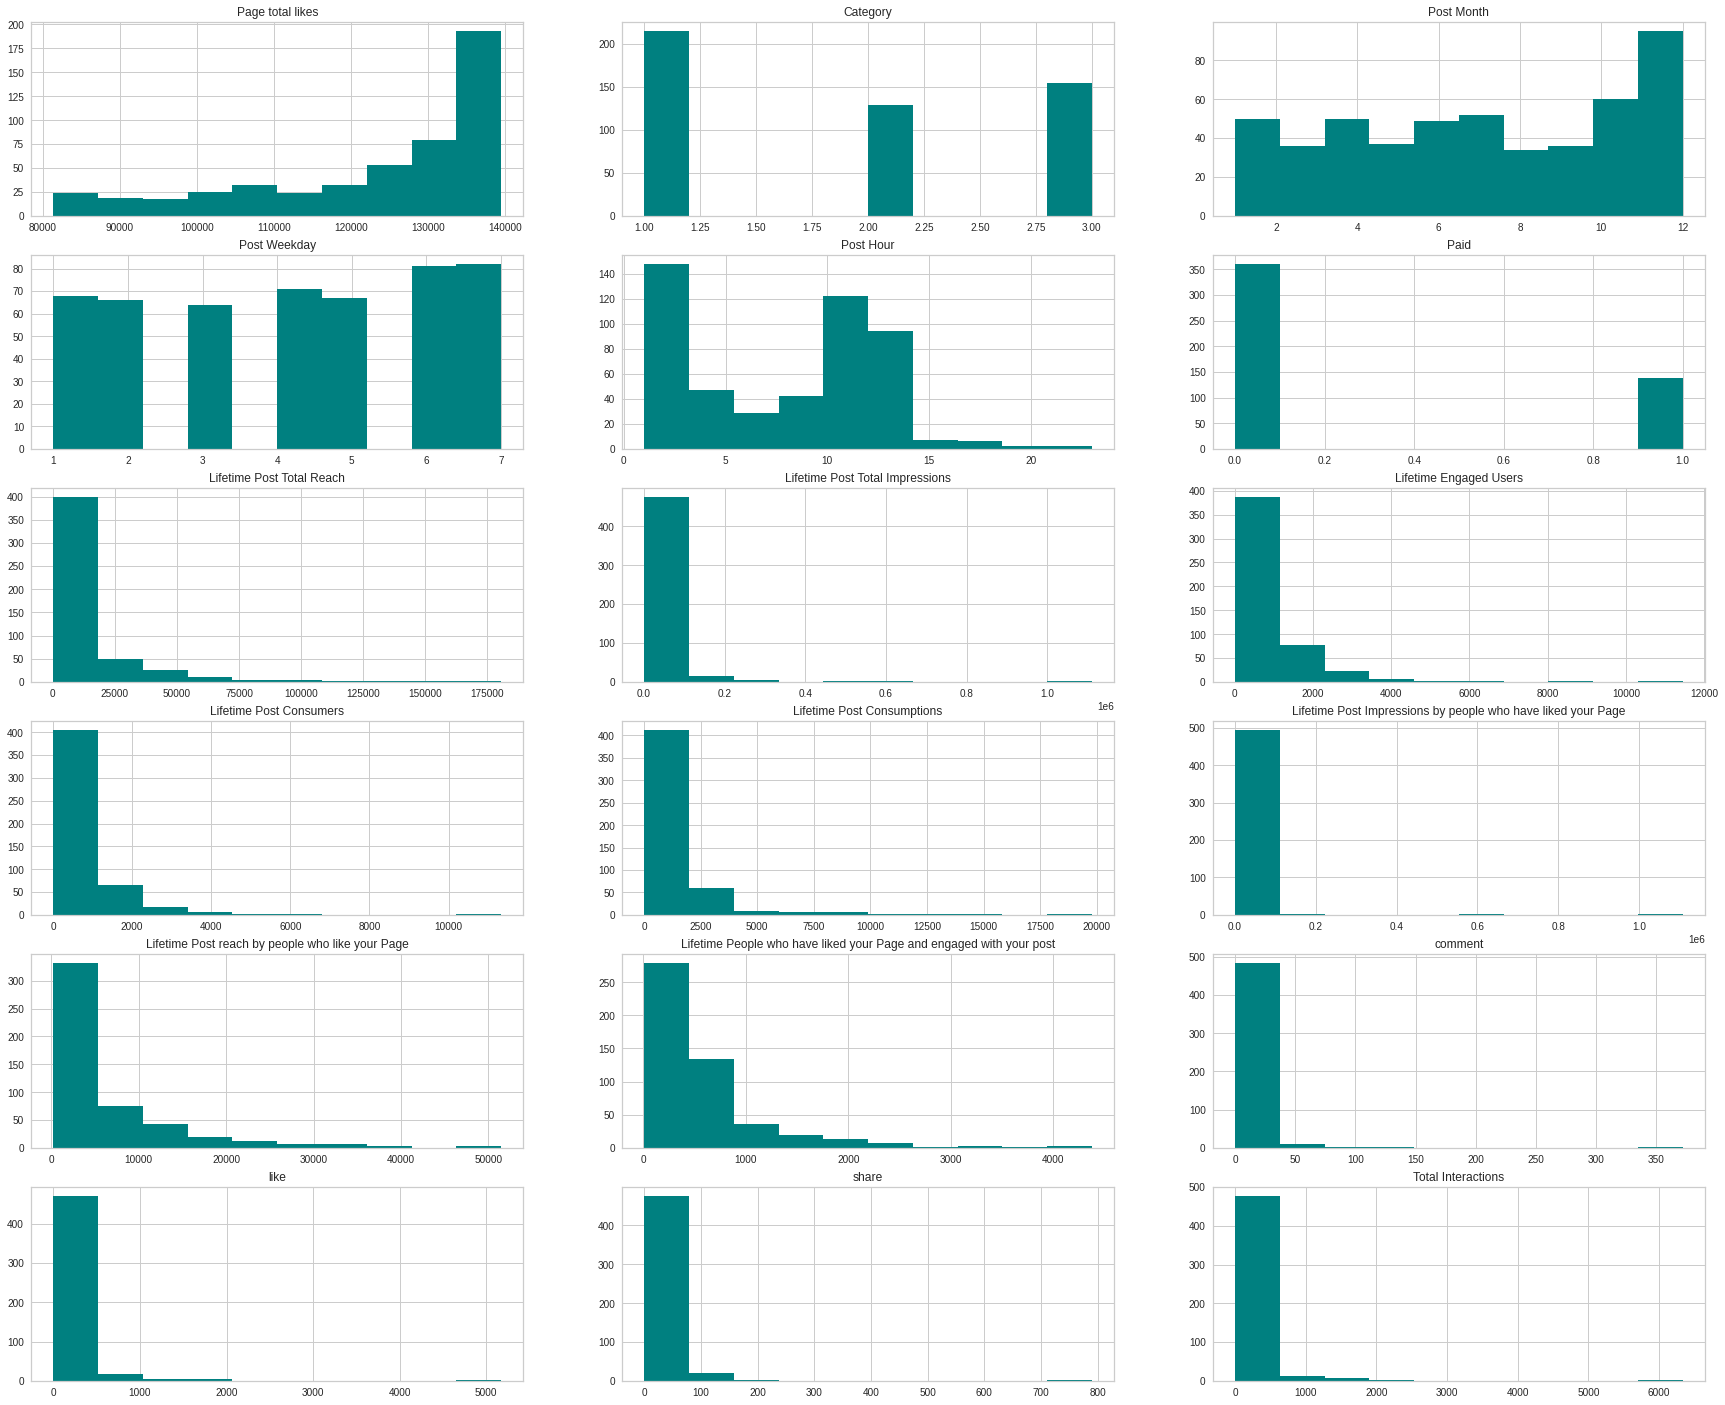

In [0]:
# Plotting histograms for numerical features
numeric_var = df.select_dtypes(include=['int','float']).columns
nvar = len(numeric_var)

fig = plt.figure(figsize=(30,25))
ncols = 3
nrows = math.ceil(nvar/ncols)

for i,column in enumerate(numeric_var):
  ax = fig.add_subplot(nrows, ncols, i + 1)
  ax.set_title(column)
  df[column].hist(axes = ax, color = 'teal')

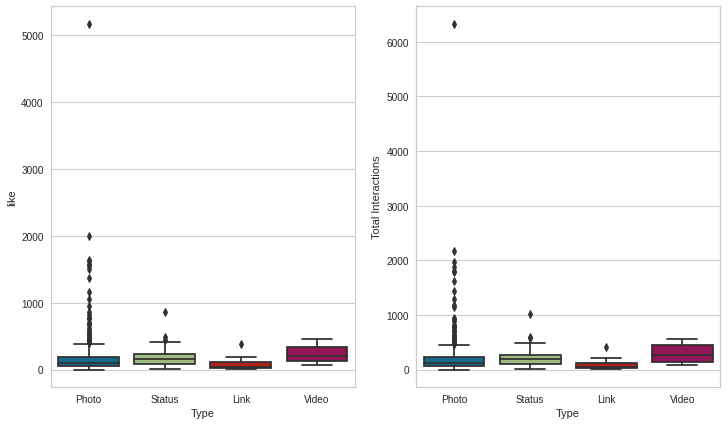

In [0]:
fig,axes = plt.subplots(1,2, figsize =(12,7) )
sns.boxplot(x=df['Type'],y=df['like'], ax = axes[0])
sns.boxplot(x=df['Type'],y=df['Total Interactions'], ax = axes[1])

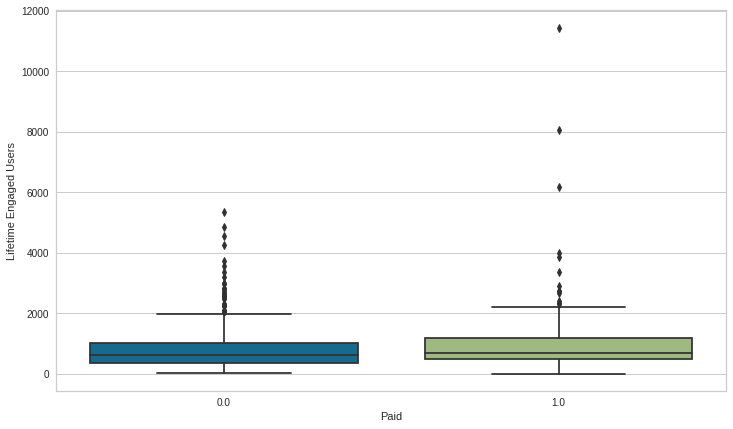

In [0]:
plt.figure(figsize=(12,7))
sns.boxplot(x=df['Paid'],y=df['Lifetime Engaged Users'])

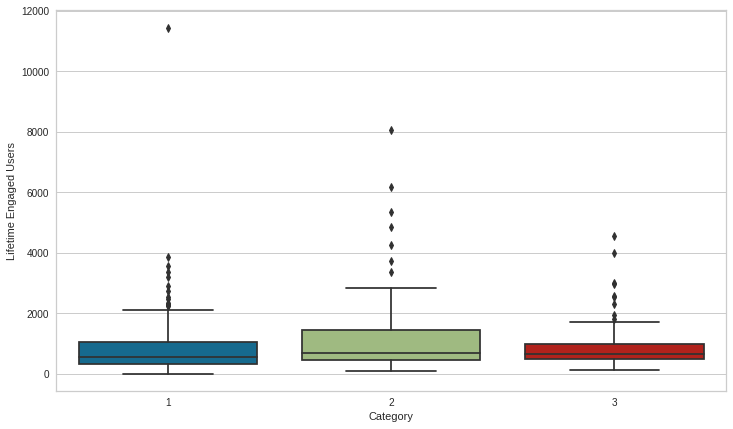

In [0]:
plt.figure(figsize=(12,7))
sns.boxplot(x=df['Category'],y=df['Lifetime Engaged Users'])

In [0]:
df.columns

Index(['Page total likes', 'Type', 'Category', 'Post Month', 'Post Weekday',
       'Post Hour', 'Paid', 'Lifetime Post Total Reach',
       'Lifetime Post Total Impressions', 'Lifetime Engaged Users',
       'Lifetime Post Consumers', 'Lifetime Post Consumptions',
       'Lifetime Post Impressions by people who have liked your Page',
       'Lifetime Post reach by people who like your Page',
       'Lifetime People who have liked your Page and engaged with your post',
       'comment', 'like', 'share', 'Total Interactions'],
      dtype='object')

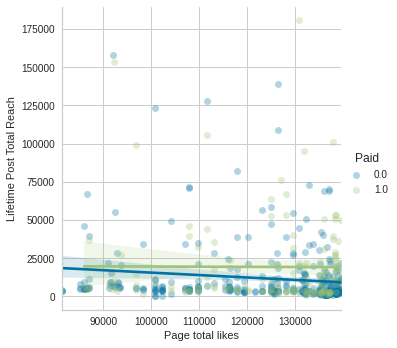

In [0]:
sns.lmplot(x='Page total likes', y='Lifetime Post Total Reach', data=df, x_jitter=1, scatter_kws={'alpha':.3},
           hue='Paid')

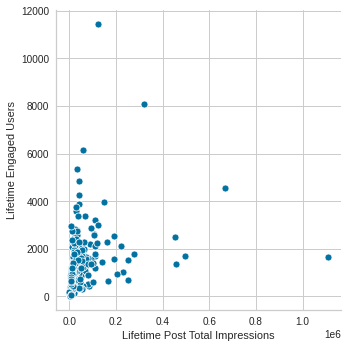

In [0]:
sns.relplot(x='Lifetime Post Total Impressions', y='Lifetime Engaged Users', data=df)

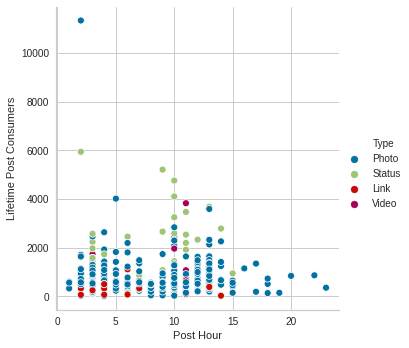

In [0]:
sns.relplot(x='Post Hour', y='Lifetime Post Consumers', data=df, hue='Type')

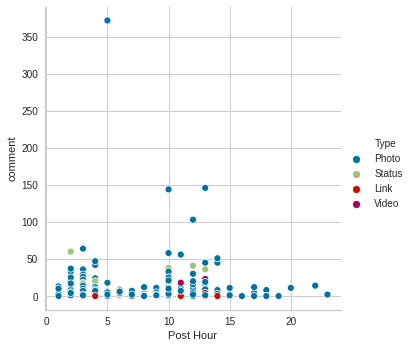

In [0]:

sns.relplot(x='Post Hour', y='comment', data=df, hue='Type')

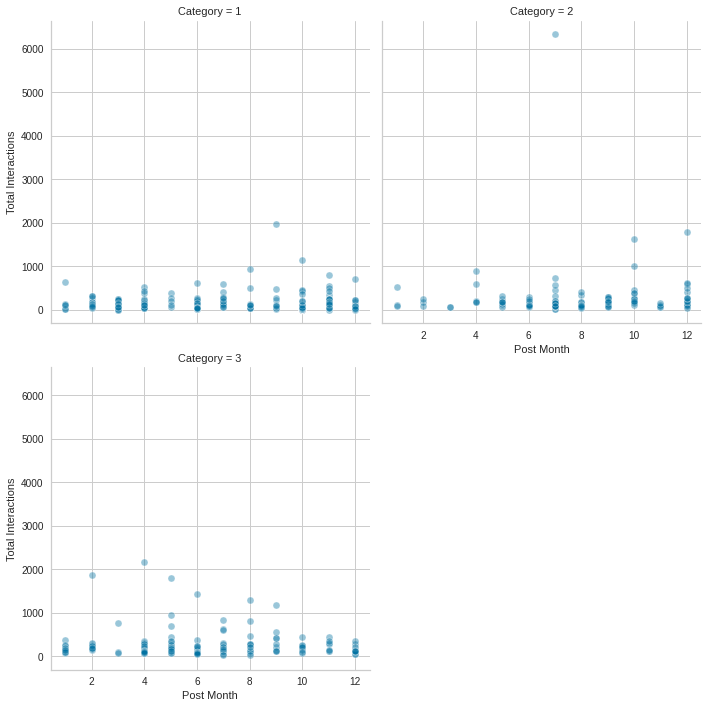

In [0]:

sns.relplot(x='Post Month', y='Total Interactions', data=df, col='Category', col_wrap=2, alpha=.4)

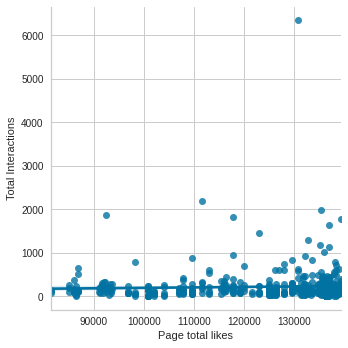

In [0]:
sns.lmplot(x='Page total likes', y='Total Interactions', data=df)

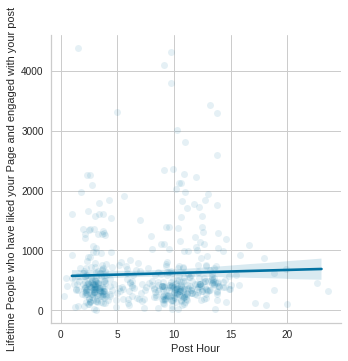

In [0]:


# lower alpha value
sns.lmplot(x='Post Hour', y='Lifetime People who have liked your Page and engaged with your post', data=df, x_jitter=1, scatter_kws={'alpha':.1})




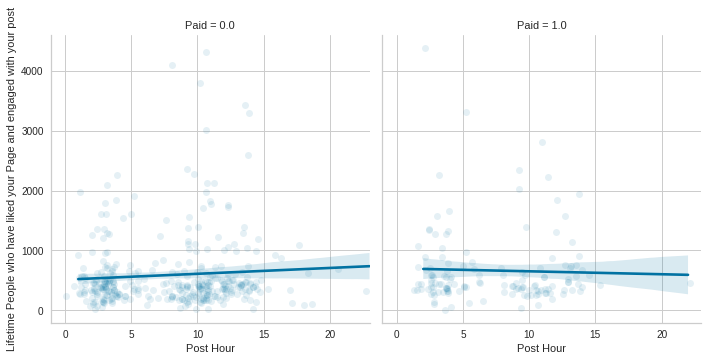

In [0]:
sns.lmplot(x='Post Hour', y='Lifetime People who have liked your Page and engaged with your post', data=df, x_jitter=1, scatter_kws={'alpha':.1},
          col='Paid', col_wrap=2)

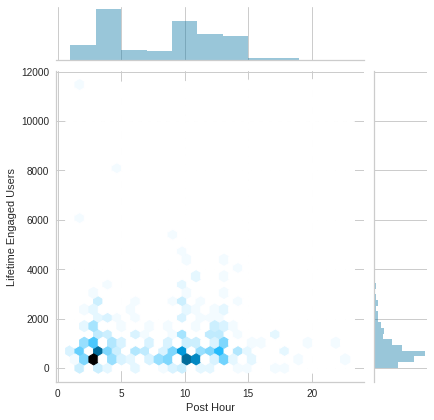

In [0]:

# combine frequency and scatter plot
sns.jointplot(x='Post Hour', y='Lifetime Engaged Users', data=df, kind='hex' )


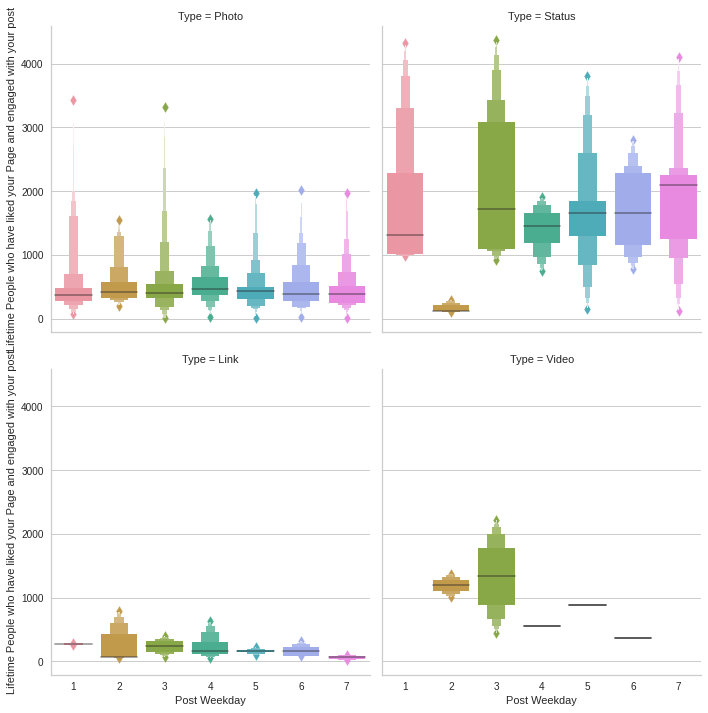

In [0]:
# Can add more dimensions with col, row
ax = sns.catplot(x='Post Weekday', y='Lifetime People who have liked your Page and engaged with your post', data=df, kind='boxen', col='Type', col_wrap=2)

In [0]:

pd.pivot_table(df, values='Lifetime Engaged Users', index='Type', aggfunc='mean')



,Lifetime Engaged Users
Type,
Link,342.818182
Photo,819.545882
Status,2040.222222
Video,1707.000000


In [0]:
pd.pivot_table(df, values='Lifetime Engaged Users', index='Paid', aggfunc='mean')

,Lifetime Engaged Users
Paid,
0.0,849.447222
1.0,1106.525180


In [0]:
pd.pivot_table(df, values='Lifetime People who have liked your Page and engaged with your post', index='Paid', aggfunc='mean')

,Lifetime People who have liked your Page and engaged with your post
Paid,
0.0,589.958333
1.0,663.971223


In [0]:
# Function Encode all Categorical variables (one hot encoding)
def one_hot_encode(var):
  return pd.get_dummies(df[var])

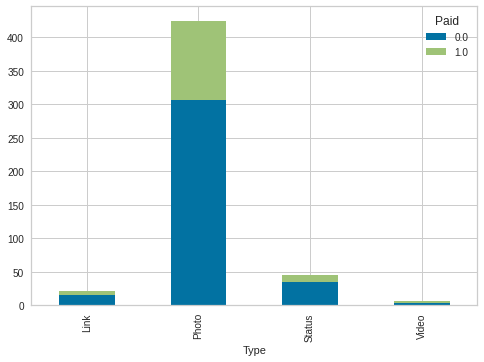

In [0]:
(df
 .pipe(lambda df2: pd.crosstab(df2.Type, df2.Paid))
 .plot.bar(stacked=True)
)

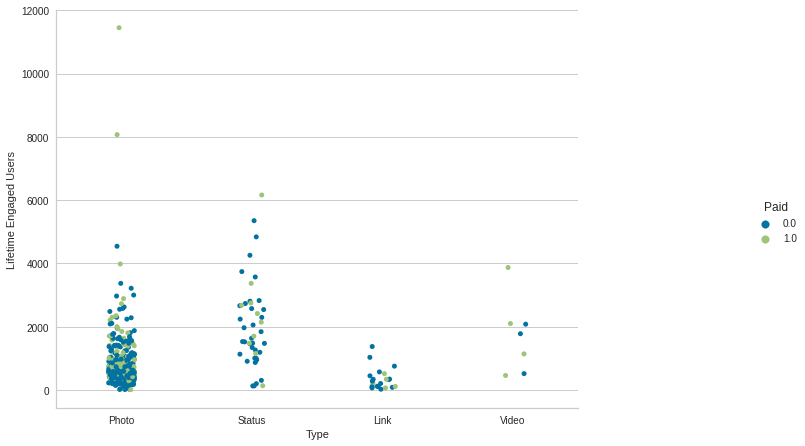

In [0]:

sns.catplot(x="Type", y ='Lifetime Engaged Users' , hue="Paid", data=df, height=4, aspect=.7)
plt.gcf().set_size_inches(15,7)

In [0]:
df.columns

Index(['Page total likes', 'Type', 'Category', 'Post Month', 'Post Weekday',
       'Post Hour', 'Paid', 'Lifetime Post Total Reach',
       'Lifetime Post Total Impressions', 'Lifetime Engaged Users',
       'Lifetime Post Consumers', 'Lifetime Post Consumptions',
       'Lifetime Post Impressions by people who have liked your Page',
       'Lifetime Post reach by people who like your Page',
       'Lifetime People who have liked your Page and engaged with your post',
       'comment', 'like', 'share', 'Total Interactions'],
      dtype='object')

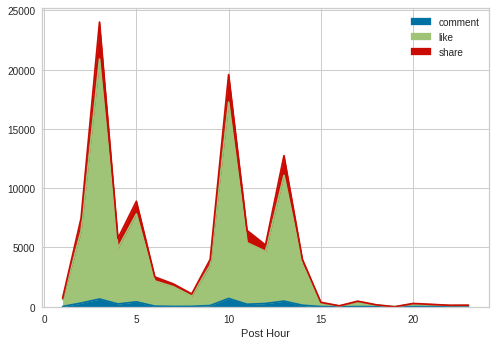

In [0]:
df_area = pd.pivot_table(data = df, values = ['like','share','comment'], index = 'Post Hour', aggfunc = 'sum')


df_area.plot.area()


In [0]:
df.groupby('Paid')['Lifetime Post Total Reach'].describe()

,count,mean,std,min,25%,50%,75%,max
Paid,,,,,,,,
0.0,360.0,11851.216667,20039.868487,238.0,3108.0,4903.0,10256.0,158208.0
1.0,139.0,19288.158273,28006.286388,813.0,3751.0,7132.0,22544.0,180480.0


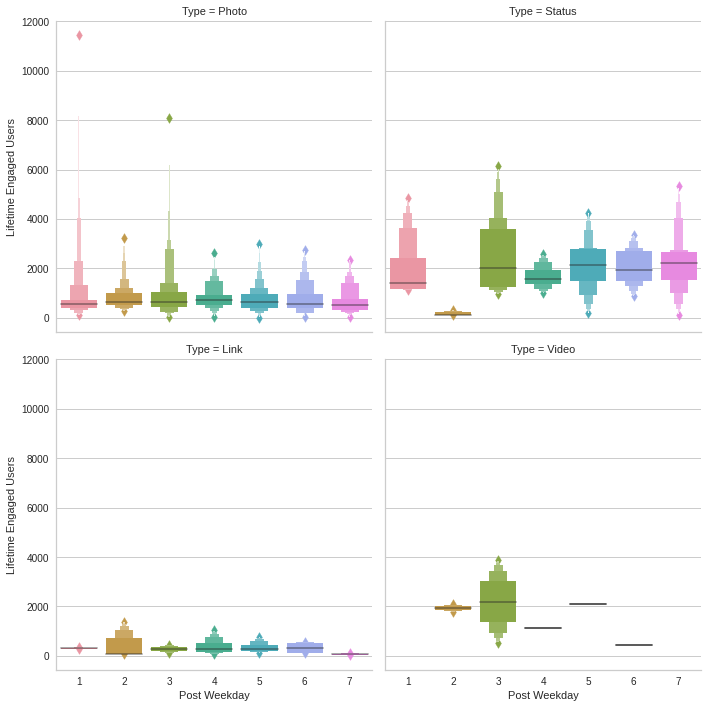

In [0]:
#Improving Plots (Week 4)

sns.catplot(x='Post Weekday', y= 'Lifetime Engaged Users', 
                 data=df, kind='boxen', col='Type', col_wrap=2)

In [0]:
sns.choose_colorbrewer_palette('qualitative')

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

[(0.8941176470588235, 0.10196078431372557, 0.10980392156862737),
 (0.21568627450980393, 0.4941176470588236, 0.7215686274509804),
 (0.3019607843137256, 0.6862745098039216, 0.29019607843137263),
 (0.5960784313725492, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (0.9999999999999998, 1.0, 0.19999999999999996),
 (0.6509803921568629, 0.33725490196078434, 0.1568627450980391),
 (0.9686274509803922, 0.5058823529411766, 0.7490196078431374),
 (0.6, 0.6, 0.6)]

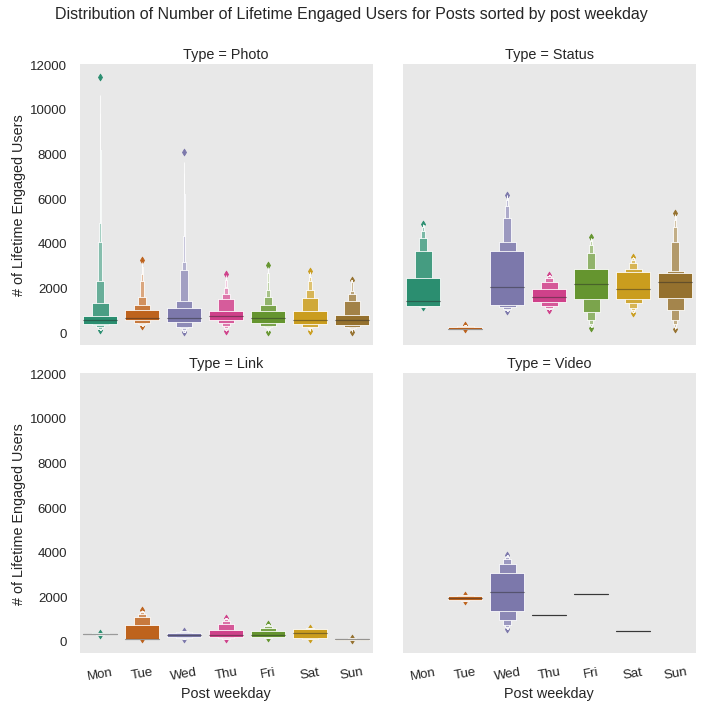

In [0]:
# Accent color palette
with sns.color_palette('Dark2'):
  with sns.plotting_context('paper', font_scale = 1.5):
    with sns.axes_style('dark', {'axes.facecolor':'E8E8E8'}):
      g = sns.catplot(x='Post Weekday', y= 'Lifetime Engaged Users',
                  data=df, kind='boxen', col='Type', col_wrap=2)
      
plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
g.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation = 10)
g.set_axis_labels("Post weekday","# of Lifetime Engaged Users")
g.fig.suptitle('Distribution of Number of Lifetime Engaged Users for Posts sorted by post weekday', fontsize = 16,)
g.fig.subplots_adjust(top=.9)

             
            

In [0]:
pd.pivot_table(df, values = 'Lifetime Engaged Users', 
               index = 'Type', columns ='Post Weekday', aggfunc = 'sum')

Post Weekday,1,2,3,4,5,6,7
Type,,,,,,,
Link,626.0,1524.0,545.0,1634.0,1430.0,1641.0,142.0
Photo,59037.0,47177.0,50277.0,51856.0,39488.0,51707.0,48765.0
Status,8799.0,569.0,20844.0,6756.0,18511.0,16425.0,19906.0
Video,NaN,3859.0,4389.0,1141.0,2101.0,459.0,NaN


In [0]:
df.columns

Index(['Page total likes', 'Type', 'Category', 'Post Month', 'Post Weekday',
       'Post Hour', 'Paid', 'Lifetime Post Total Reach',
       'Lifetime Post Total Impressions', 'Lifetime Engaged Users',
       'Lifetime Post Consumers', 'Lifetime Post Consumptions',
       'Lifetime Post Impressions by people who have liked your Page',
       'Lifetime Post reach by people who like your Page',
       'Lifetime People who have liked your Page and engaged with your post',
       'comment', 'like', 'share', 'Total Interactions'],
      dtype='object')

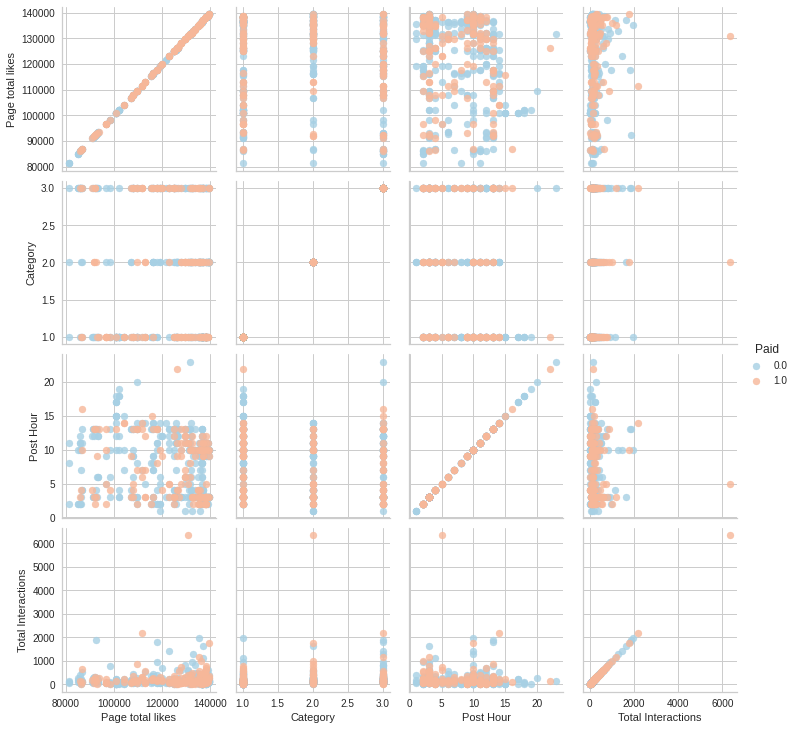

In [0]:
g = sns.PairGrid(df, vars=['Page total likes', 'Category', 'Post Hour','Total Interactions'],
                 hue='Paid', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend()

In [0]:
df.dtypes

Page total likes                                                         int64
Type                                                                    object
Category                                                                 int64
Post Month                                                               int64
Post Weekday                                                             int64
Post Hour                                                                int64
Paid                                                                   float64
Lifetime Post Total Reach                                                int64
Lifetime Post Total Impressions                                          int64
Lifetime Engaged Users                                                   int64
Lifetime Post Consumers                                                  int64
Lifetime Post Consumptions                                               int64
Lifetime Post Impressions by people who have liked y

In [0]:
def data_transform(df):
    """Normalize features."""
    X = pd.get_dummies(df)
    feature_cols = X[X.columns]
    std = preprocessing.StandardScaler()
    X_std = pd.DataFrame(std.fit_transform(feature_cols), columns=feature_cols.columns)
    return X, X-X_std

In [0]:
X, X_std = data_transform(df)

In [0]:
X.head()

,Page total likes,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions,Type_Link,Type_Photo,Type_Status,Type_Video
0,139441,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100,0,1,0,0
1,139441,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164,0,0,1,0
2,139441,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80,0,1,0,0
3,139441,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777,0,1,0,0
4,139441,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393,0,1,0,0


In [0]:
pca = decomposition.PCA()
pca_X = pd.DataFrame(pca.fit_transform(X_std), columns=[f'PC{i+1}' for i in range(len(X.columns))])
pca_X

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22
0,-29749.372634,7075.099538,-15723.377236,4400.137168,1231.720113,-647.430616,179.839626,41.962146,89.101058,-1.210281,-4.456050,0.258751,-3.047390,0.087544,0.192357,0.018444,-1.186053,0.028631,-0.181198,0.047066,3.029642e-14,4.390790e-16
1,-12211.555556,2880.723190,-15898.059458,-559.490396,-271.922110,918.859443,-734.014328,-179.333208,-87.101551,7.133634,-13.762865,-3.027757,2.282373,-0.390481,1.458516,-0.605559,-0.718054,1.616480,0.178591,0.022762,-1.771029e-13,-1.527394e-15
2,-30532.797907,7381.459383,-15709.388200,4503.323215,1265.569651,-629.550040,165.351668,23.110656,74.720297,5.221194,-4.371718,-1.978048,-2.997679,-0.435022,0.282204,-0.021401,-1.192395,0.001423,-0.175626,0.208415,-2.921982e-13,-2.620585e-18
3,78639.095083,-13879.498544,-16832.330695,-29254.980846,-7853.797475,-3102.138228,219.182977,1177.625856,411.648734,134.495463,-33.335702,-0.966874,1.858910,-0.529920,1.068564,0.249165,-0.634517,-0.095796,0.678859,-0.017014,5.804618e-13,-4.753790e-16
4,-20400.453196,3179.696287,-15868.265523,2801.766277,986.565566,-245.119757,-141.100132,335.166982,65.204079,3.141683,-6.594896,0.687452,-2.960789,-0.876323,0.456356,-0.015777,-1.190286,-0.092379,-0.216311,0.011417,8.145316e-15,-4.451834e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,-23463.950195,5202.440883,38526.874505,4522.819558,-114.723637,-541.533989,-257.162914,178.299611,-57.211085,-15.165021,-5.943205,-0.902750,0.763040,1.371374,-0.033540,0.349525,-0.802311,0.146994,-0.156701,0.149006,4.789291e-15,-1.272319e-16
495,-25454.799924,5678.352644,38558.324609,4824.952827,-10.106086,-547.108772,-189.524846,84.105181,-73.884428,4.443785,-12.150358,0.839793,-5.606386,1.360303,-0.312244,0.646950,-0.675887,0.118518,-0.277077,0.133097,-1.341610e-14,-2.407280e-16
496,-27105.422382,6337.088319,42277.487969,5941.127173,209.530458,-882.484488,-101.941841,139.121382,-122.371247,13.007992,-7.759310,-1.411818,-1.113432,0.400866,0.353267,0.477027,-1.188864,0.209072,-0.092053,-0.036575,-9.198777e-15,-2.583740e-16
497,-25803.321220,6299.315240,42260.194547,5725.136202,58.345931,-771.699497,-158.576775,180.280387,-129.093876,16.862930,0.030660,3.618260,-6.002930,0.490906,0.218929,0.711058,-1.191433,0.241443,-0.176044,-0.227440,2.340451e-14,-1.849621e-16


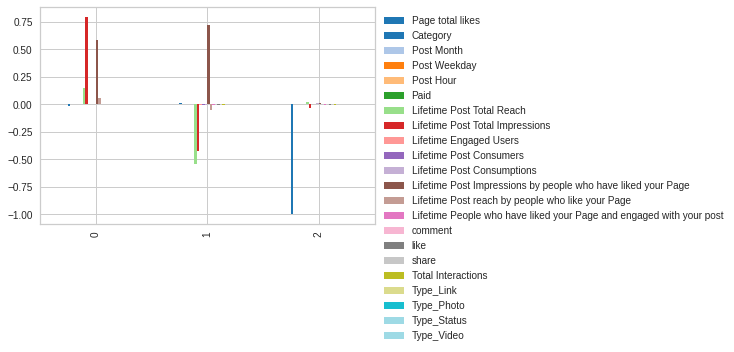

In [0]:
(pd.DataFrame(pca.components_, columns=X.columns)
 .iloc[:3]
 .plot.bar(cmap = 'tab20')
 .legend(bbox_to_anchor=(1,1)))

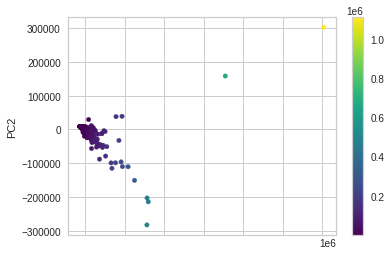

In [0]:

pca_X.plot.scatter(x='PC1', y='PC2', c = X_std['Lifetime Post Total Impressions'], cmap = 'viridis')

In [0]:
pca.explained_variance_ratio_

array([8.74497402e-01, 8.77668398e-02, 2.50557330e-02, 1.14171871e-02,
       7.98829885e-04, 3.83364211e-04, 6.09298463e-05, 1.46509287e-05,
       4.93320201e-06, 1.01613952e-07, 1.91542903e-08, 8.23724954e-09,
       1.03236766e-09, 1.01237177e-10, 8.23229182e-11, 6.58463768e-11,
       4.74809003e-11, 3.10333492e-11, 2.75614625e-11, 1.55421367e-12,
       5.59540537e-37, 1.01317980e-41])

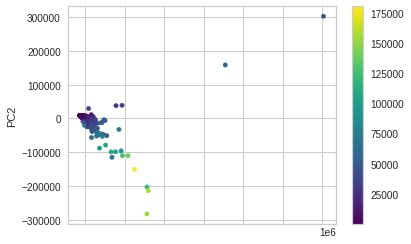

In [0]:

pca_X.plot.scatter(x='PC1', y='PC2', c = X['Lifetime Post Total Reach'], cmap = 'viridis')

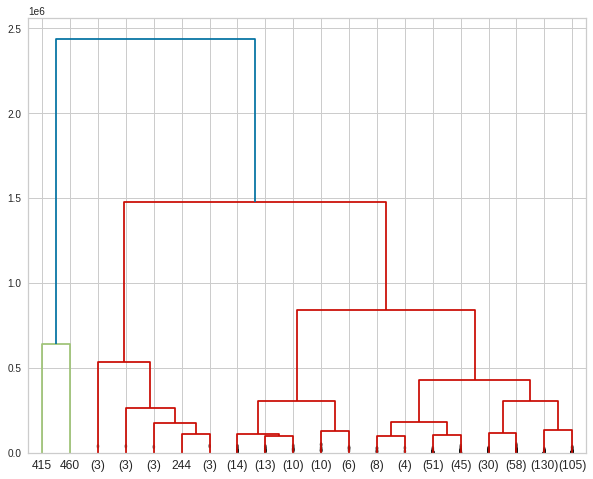

In [0]:
fig, ax = plt.subplots(figsize=(10,8))
hierarchy.dendrogram(hierarchy.linkage(X_std, method='ward'),truncate_mode='lastp', p=20, show_contracted=True)

pass

In [0]:
agg = cluster.AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
agg.fit(X_std)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=3)

In [0]:
X.assign(label = agg.labels_).groupby('label').agg(['mean', 'std', 'min', 'max'])

Page total likes                       ... Type_Video        
                  mean           std    min  ...        std min max
label                                        ...                   
0        123571.557851  16043.673377  81370  ...   0.101218   0   1
1         98288.500000   8176.275711  92507  ...   0.000000   0   0
2        116192.846154  18372.563443  92079  ...   0.375534   0   1

[3 rows x 88 columns]

In [0]:
agg = cluster.AgglomerativeClustering(n_clusters =2, affinity = 'euclidean', linkage = 'ward')
agg.fit(X_std)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2)

In [0]:
X.assign(label = agg.labels_).groupby('label').agg(['mean', 'std', 'min', 'max'])

Page total likes                       ... Type_Video        
                  mean           std    min  ...        std min max
label                                        ...                   
0         123378.55332  16131.005159  81370  ...   0.117958   0   1
1          98288.50000   8176.275711  92507  ...   0.000000   0   0

[2 rows x 88 columns]